<a href="https://colab.research.google.com/github/isaacspidey/viu_aprendizaje_supervisado/blob/main/Actividad_Computer_Vision_C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 0) Cargar una de las imágenes histológicas

In [55]:
import cv2
from google.colab.patches import cv2_imshow

from skimage import io
from skimage import morphology
from skimage import measure
from skimage.measure import regionprops

from scipy.ndimage import binary_fill_holes

from sklearn import preprocessing

import matplotlib.pyplot as plt

import numpy as np

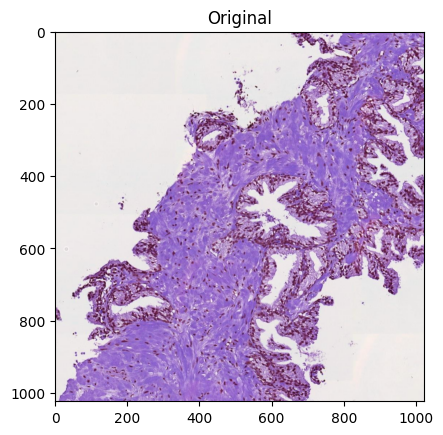

In [56]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.

source='histo_1.jpg'

img_BGR = io.imread(source)
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

plt.title('Original')
plt.imshow(img_RGB)
plt.show()

In [57]:
#Aplanamos en forma de vector columna para poder normalizar
img_flattened = img_RGB.reshape(-1, 1)

In [58]:
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
normalizer = preprocessing.MinMaxScaler()
img_flattened_normalized = normalizer.fit_transform(img_flattened)


img_normalized = img_flattened_normalized.reshape(img_RGB.shape)

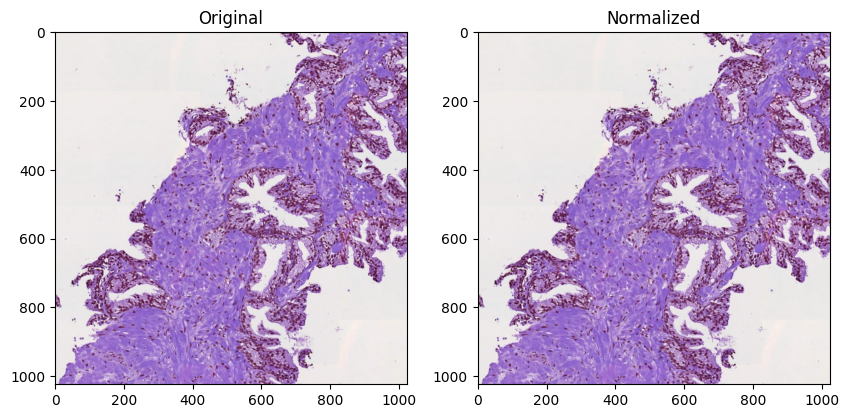

In [59]:
# Visualizar la imagen original y la normalizada una al lado de la otra
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_RGB)
axes[0].set_title('Original')

axes[1].imshow(img_normalized)
axes[1].set_title('Normalized')

plt.show()

## Convocatoria 1 - Proyecto 1

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [60]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
with np.errstate(invalid='ignore', divide='ignore'):

  K = 1 - np.max(img_normalized, axis=2)
  C = (1-img_normalized[:,:,0]-K)/(1-K)
  M = (1-img_normalized[:,:,1]-K)/(1-K)
  Y = (1-img_normalized[:,:,2]-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)

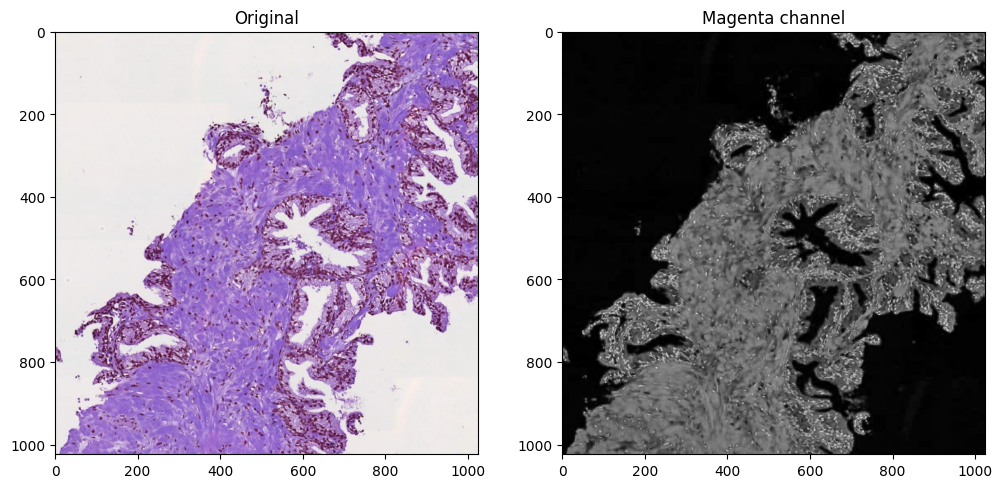

In [61]:
# Visualizar la imagen del canal magenta
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img_RGB)
ax[0].set_title('Original')

ax[1].imshow(M.astype('uint8'), cmap='gray')
ax[1].set_title('Magenta channel')

plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

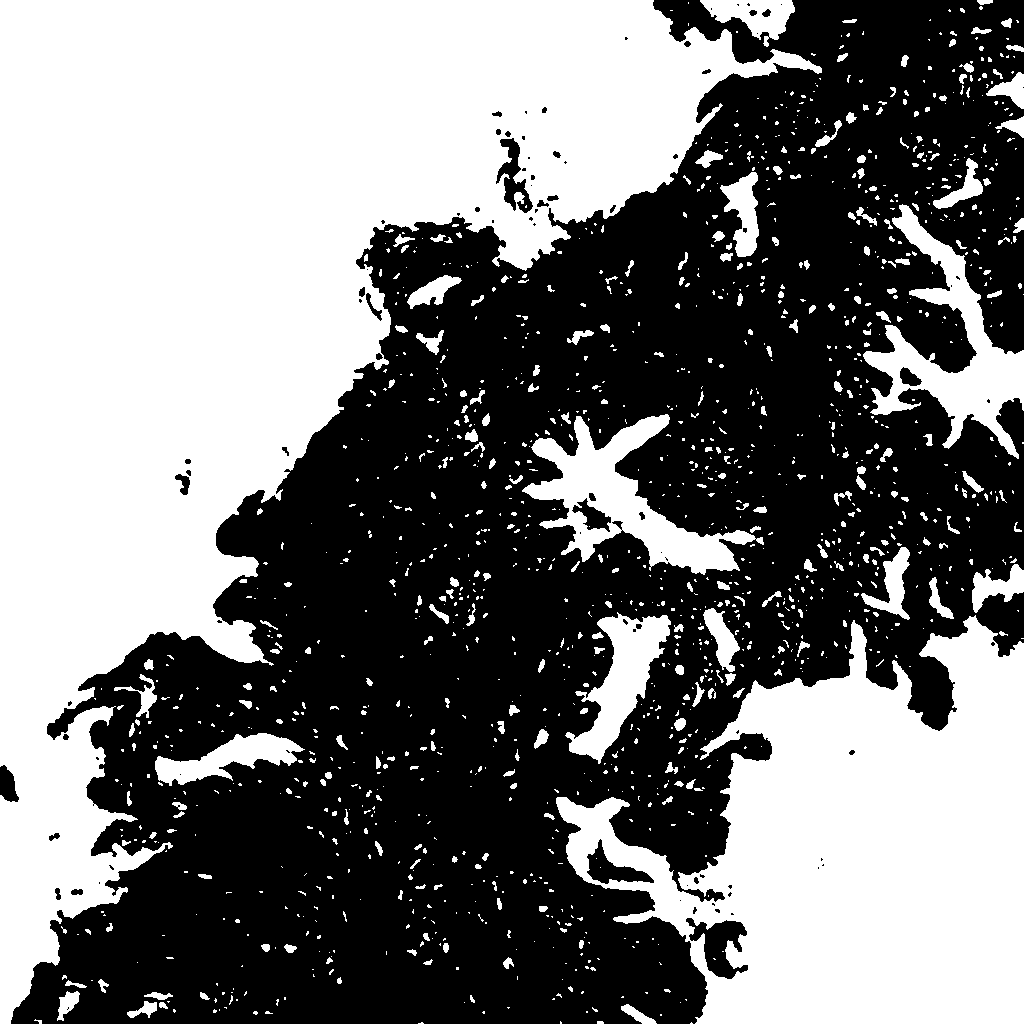

In [62]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

#Aplicamos filtro gaussiano y aplicamos escala de grises
img = cv2.imread(source)
img_blurred = cv2.GaussianBlur(img, (5,5), 0)
img_blurred_grayscale = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY)

#Otsu
_, img_thresholed = cv2.threshold(img_blurred_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Visualizar la máscara resultante
cv2_imshow(img_thresholed)

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

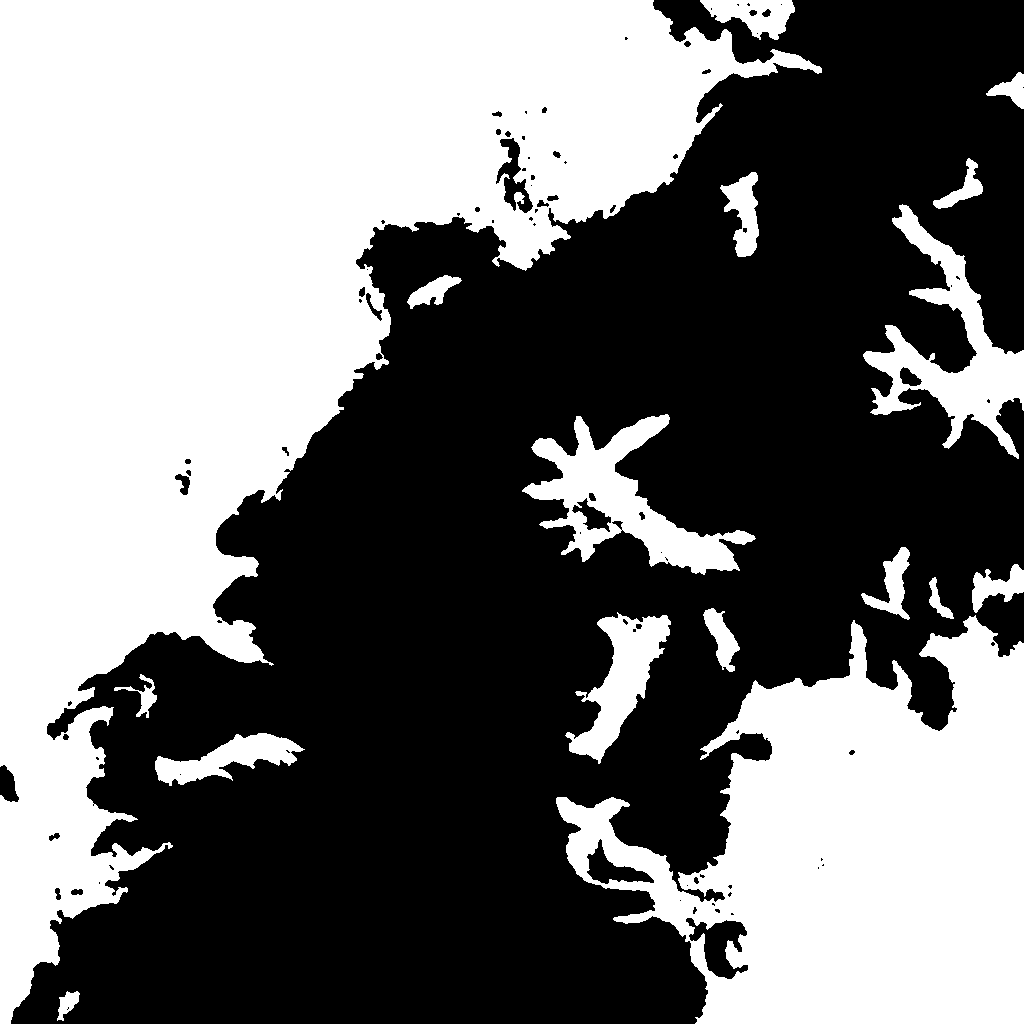

In [63]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
img_purged_mask = morphology.remove_small_objects(img_thresholed.astype(bool), min_size=300)

# Visualizar la máscara resultante
img_purged=img_purged_mask.astype(np.uint8)*255
cv2_imshow(img_purged)

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [64]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

def flood_fill(image, seed, fill_value):

  h, w = image.shape[:2]
  visited = np.zeros((h, w), dtype=bool)
  stack = [seed]
  original_value = image[seed[0], seed[1]]

  while stack:
    y, x = stack.pop()

    if 0 <= x < w and 0 <= y < h and not visited[y, x]:
      if image[y, x] == original_value:

        image[y, x] = fill_value
        visited[y, x] = True
        stack.extend([(y+1, x), (y-1, x), (y, x+1), (y, x-1)])

  return image

In [65]:
def antimage(image): #Hay que tener cuidado al usar esta funcion porque tratando con máscaras no funciona bien. Con máscaras hay que utilizar el inversor de bit ~
  return 255 - image

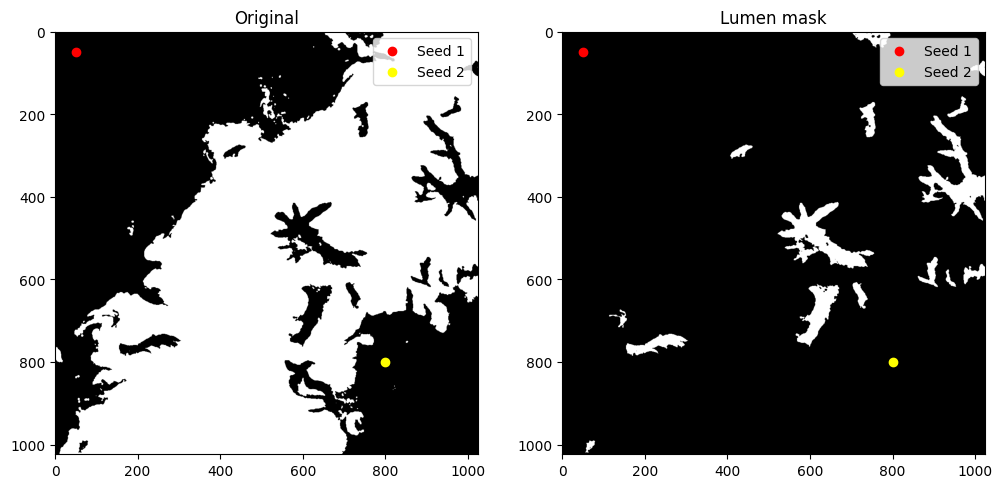

In [66]:
def region_growing(image, seed1=(50, 50), seed2=(800, 800)):

  inverted_image = antimage(image.copy())

  filled_image = flood_fill(inverted_image, seed1, 255)
  filled_image = flood_fill(filled_image, seed2, 255)

  plt.figure(figsize=(12, 6))


  plt.subplot(1, 2, 1)
  plt.title("Original")
  plt.imshow(img_purged, cmap='binary')
  plt.scatter(seed1[1], seed1[0], color='red', marker='o', label='Seed 1')
  plt.scatter(seed2[1], seed2[0], color='yellow', marker='o', label='Seed 2')

  plt.legend()


  plt.subplot(1, 2, 2)
  plt.title("Lumen mask")
  plt.imshow(filled_image, cmap='binary')
  plt.scatter(seed1[1], seed1[0], color='red', marker='o', label='Seed 1')
  plt.scatter(seed2[1], seed2[0], color='yellow', marker='o', label='Seed 2')

  plt.legend()


  return filled_image

#Aplicamos region growing para obtener la mascara de los lumenes
lumen_mask = region_growing(img_purged)

#### 5) Rellenar los objetos de los lúmenes

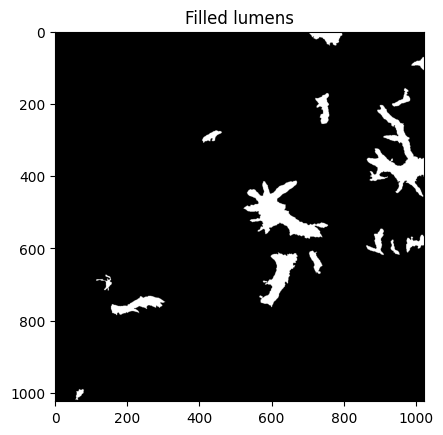

In [67]:
#Rellenamos con la funcion del enunciado

filled_lumen_holes = binary_fill_holes(~lumen_mask)
filled_lumen_holes= ~filled_lumen_holes

plt.imshow(filled_lumen_holes, cmap='binary')
plt.title("Filled lumens")
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

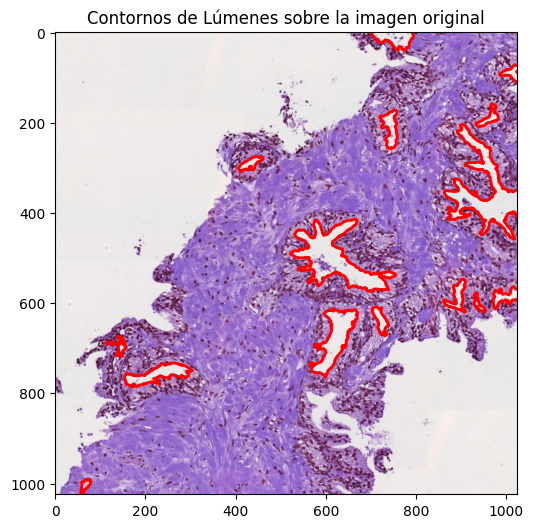

In [68]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta


def draw_lumen(image, lumens_mask):

  #Cuales son los contornos
  contours = measure.find_contours(lumens_mask, 0.5)

  # Dibujar los contornos en la imagen
  plt.figure(figsize=(12, 6))
  plt.imshow(image, cmap='gray')
  plt.title("Contornos de Lúmenes sobre la imagen original")

  for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color="red", linewidth=2)

  plt.show()

#Dibujamos
draw_lumen(img_RGB, filled_lumen_holes)

#### 7) Identificar y cropear el lumen más grande

In [69]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.

def find_largest_contour(contours):

  max_area = 0
  largest_contour = None

  for contour in contours:
    area = cv2.contourArea(contour.astype(np.int32))
    if area > max_area:
      max_area = area
      largest_contour = contour

  return largest_contour

In [70]:
def crop_largest_lumen(image, lumens_mask):

    contours = measure.find_contours(lumens_mask, 0.5)
    largest_contour = find_largest_contour(contours)

    # Obtener los límites del rectángulo que contiene el contorno de mayor área
    y_min, x_min = largest_contour.min(axis=0)
    y_max, x_max = largest_contour.max(axis=0)

    # Recortar la región de interés de la imagen original
    cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    return cropped_image

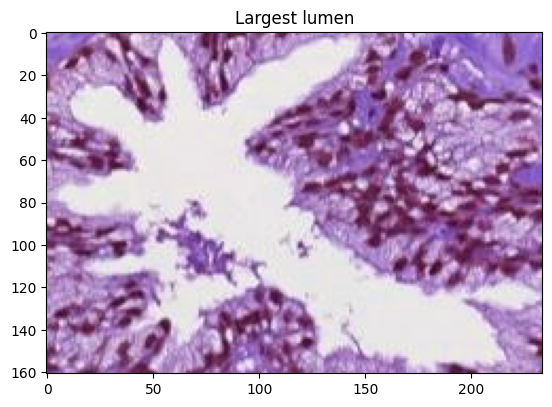

In [71]:
# Recortar el lumen de mayor área
cropped_lumen = crop_largest_lumen(img_RGB, filled_lumen_holes)

# Visualizar el lumen cropeado
plt.figure()
plt.imshow(cropped_lumen)
plt.title("Largest lumen")
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [72]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad


def calculate_features(image):

  #Convertimos a escala de grises
  if len(image.shape) > 2:
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  else:
    image_gray = image

  #Binarizar
  _, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY)

  #Contornos
  contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = max(contours, key=cv2.contourArea)

  #Mascara para el contorno mayor
  mask = np.zeros_like(image_gray)
  cv2.drawContours(mask, [largest_contour], 0, 255, -1)

  #Características
  props = regionprops(mask.astype(int))

  features = {
    'Área': round(props[0].area, 4),
    'Área de la bounding box': round(props[0].bbox_area, 4),
    'Área convexa': round(props[0].convex_area, 4),
    'Excentricidad': round(props[0].eccentricity, 4),
    'Diámetro equivalente': round(props[0].equivalent_diameter, 4),
    'Extensión': round(props[0].extent, 4),
    'Diámetro Feret': round(props[0].feret_diameter_max, 4),
    'Longitud del eje mayor': round(props[0].major_axis_length, 4),
    'Longitud del eje menor': round(props[0].minor_axis_length, 4),
    'Orientación': round(props[0].orientation, 4),
    'Perímetro': round(props[0].perimeter, 4),
    'Solidez': round(props[0].solidity, 4),
    'Compacidad': round(4 * np.pi * props[0].area / (props[0].perimeter **2), 4)
    }

  return features


#Mostramos lo calculado
features = calculate_features(cropped_lumen)

for key, value in features.items():
  print(f'{key}: {value}')

Área: 37674.0
Área de la bounding box: 37674.0
Área convexa: 37674.0
Excentricidad: 0.7257
Diámetro equivalente: 219.016
Extensión: 1.0
Diámetro Feret: 283.4713
Longitud del eje mayor: 270.1975
Longitud del eje menor: 185.9032
Orientación: 1.5708
Perímetro: 786.0
Solidez: 1.0
Compacidad: 0.7663


In [73]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#